# Poisson Regression

Gaussian process models can be incredibly flexbile for modelling non-Gaussian data. One such example is in the case of count data which can be modelled with a __Poisson model__ with a latent Gaussian process.
$$
\mathbf{y} \ | \ \mathbf{f} \sim \prod_{i=1}^{n} \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},
$$
where $\lambda_i=\exp(f_i)$.



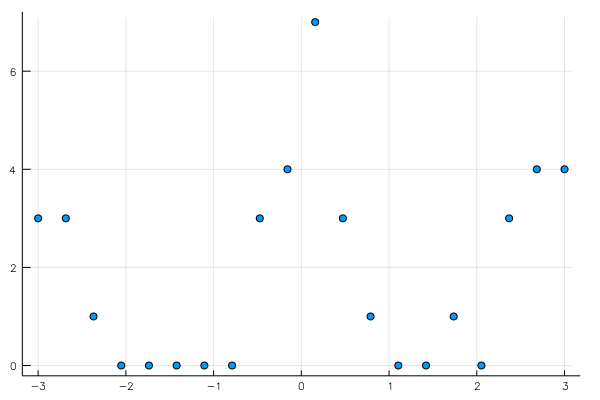

In [1]:
#Load the package
using GaussianProcesses

#Simulate the data
srand(203617)
n = 20
X = collect(linspace(-3,3,n));
f = 2*cos.(2*X);
Y = [rand(Distributions.Poisson(exp.(f[i]))) for i in 1:n];

#Plot the data using the Plots.jl package with the GR backend
using Plots
gr()
scatter(X,Y,leg=false, fmt=:png)

In [2]:
#GP set-up
k = Matern(3/2,0.0,0.0)   # Matern 3/2 kernel
l = PoisLik()             # Poisson likelihood
gp = GP(X, vec(Y), MeanZero(), k, l)

GP Monte Carlo object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.Mat32Iso, Params: [0.0, 0.0]
  Likelihood:
    Type: GaussianProcesses.PoisLik, Params: Any[]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [3, 3, 1, 0, 0, 0, 0, 0, 3, 4, 7, 3, 1, 0, 0, 1, 0, 3, 4, 4]
  Log-posterior = -65.397

In [3]:
set_priors!(gp.k,[Distributions.Normal(-2.0,4.0),Distributions.Normal(-2.0,4.0)])

samples = mcmc(gp;nIter=50000, thin=10, burnin=10000)

BasicMCJob:
  Variable [1]: p (BasicContMuvParameter)
  GenericModel: 1 variables, 0 dependencies (directed graph)
  HMC sampler: number of leaps = 10, leap step = 0.1
  VanillaMCTuner: period = 100, verbose = false
  BasicMCRange: number of steps = 49991, burnin = 10000, thinning = 10


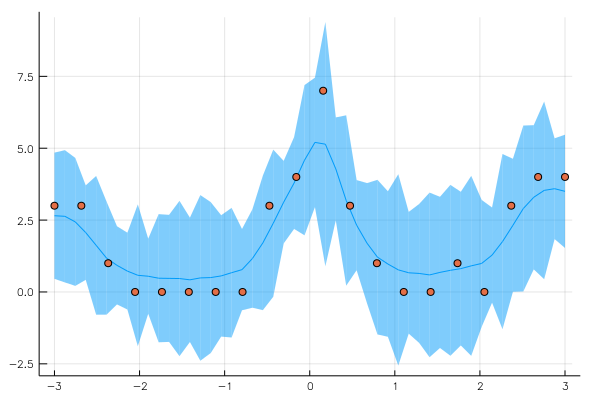

In [4]:
#Sample predicted values
xtest = linspace(minimum(gp.X),maximum(gp.X),50);
ymean = [];
fsamples = [];
for i in 1:size(samples,2)
    set_params!(gp,samples[:,i])
    update_target!(gp)
    push!(ymean, predict_y(gp,xtest)[1])
    push!(fsamples,rand(gp,xtest))
end

#Predictive plots

sd = [std(fsamples[i]) for i in 1:50]
plot(xtest,mean(ymean),ribbon=2*sd,leg=false, fmt=:png)
scatter!(X,Y)